# How to build up the final application

1. We need to be able to upload an image. It needs to be a merged image. The user needs to input the image path
2. Isolate the DAPI channel of the image and save it.
3. Get input of the user for the nucleus detection. Inputs to detect the correct shapes: 
    - Kernelsize to fill wholes in the objects (default is 5, which makes a 5x5 kernel, it should be smaller, if objects need to be better separated, but it is too small, segmented nuclei will be detected worse)
    - diversion from an aspection ratio of 1 (range: 0-1, default is 0.4, an aspect ratio of 1 is for perfect round shapes, it is a ratio of width and height, the number given here will be subtracted from 1, thus the closer to one the input, the less the restriction)
    - diversion from a circularity of 1 (range: 0-1, default is 0.7, a circularity of 1 is for perfect round shapes, the number given here will be subtracted from 1, thus the closer to one the input, the less the restriction)
    - max and min shape size (default min at 300 and max at 10000, which is hardly any restriction)
    - checkbox, if the user wants to have all the intermediate images (nucleus detection and subimages)
4. Give out nucleus detection images to the user. The user can confirm them (continue with the program) or deny them to change the settings further
5. Use the coordinates from the nucleus detection to generate the subimages from the merged image
6. Run preprocessing with the subimages: grey scale conversion, standardisation, PCA, then run the logistic regression
7. Output: intermediate images, if ticked earlier. Otherwise give a spreadsheet with the image name (mother image name and subimage number), the predicted category, the probabilites for each category and the total counts of both categories for the mother image

In [1]:
# import the needed packages
import cv2
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from PIL import Image

In [2]:
# user input

image_path = '../data/test_images_for_app'

subimages_output_folder = "../data/subimages"

# size of the kernel that is used to close holes in objects (if smaller the objects are more separated). inputing 5 will generate a 5x5 kernel
kernelsize = 5

# aspect ratio treshold, how much is the shape allowed from the ratio of 1, which would indicate that hight and width are identical (0.4 was good)
aspect = 1

# circularity treshold, it is 1 for a perfect circle. How much is the object allowed to diverge from that? (0.7 was good)
circ = 1

# decide for min and max area of the detected object
min_size = 300
max_size = 10000

# if this boolean is set to True, you will follow the nuclei detection for each image one by one and have to push any button to continue
follow_nuclei_detection = False

In [3]:
# Function to load a TIFF image, split into channels, and save the first channel and the whole image
# Function to load an image, split into channels, and save the DAPI (blue) channel
def process_image(image_path):
    image = Image.open(image_path)
    image_array = np.array(image)
    # Ensure the image has three channels (RGB)
    if len(image_array.shape) != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image must be an RGB image.")
    # Extract the blue channel (DAPI channel)
    dapi_channel = image_array[:, :, 2]
    return image_array, dapi_channel


In [4]:
# Function to detect the nuclei
def detect_objects2(image_array, output_dir, image_name, kernelsize, aspect, circ, min_size, max_size, follow_nuclei_detection=False):
    if len(image_array.shape) != 2:
        raise ValueError("Expected grayscale image")
    blurred = cv2.GaussianBlur(image_array, (11, 11), 0)
    _, thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    kernel = np.ones((kernelsize, kernelsize), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    dilated = cv2.dilate(closing, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_image = cv2.cvtColor(image_array, cv2.COLOR_GRAY2BGR)
    coordinates = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            if 1 - aspect <= aspect_ratio <= 1 + aspect and circularity > 1 - circ and min_size <= area <= max_size:
                coordinates.append((cX, cY))
                cv2.circle(color_image, (cX, cY), 5, (0, 0, 255), -1)
    output_image_path = os.path.join(output_dir, f"{image_name}_detected_centers.png")
    cv2.imwrite(output_image_path, color_image)
    if follow_nuclei_detection:
        cv2.imshow("Detected Centers", color_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return coordinates

In [5]:
# now we use these coordinates to do the subimaging on the merge-channel images

# Function to extract sub-images around detected nuclei
def extract_sub_images(image_array, coordinates, output_dir, image_name):
    if image_array is None:
        raise ValueError("Image array is None")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    sub_images = []
    for i, (cX, cY) in enumerate(coordinates):
        startX = max(cX - 30, 0)
        startY = max(cY - 30, 0)
        endX = min(cX + 30, image_array.shape[1])
        endY = min(cY + 30, image_array.shape[0])
        sub_image = image_array[startY:endY, startX:endX]
        sub_images.append(sub_image)
        sub_image_path = os.path.join(output_dir, f"{image_name}_sub_image_{i}.png")
        cv2.imwrite(sub_image_path, cv2.cvtColor(sub_image, cv2.COLOR_RGB2BGR))
    return sub_images

In [6]:
# Main function to process images
def main(image_path, subimages_output_folder, kernelsize, aspect, circ, min_size, max_size):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    output_folder = os.path.join(subimages_output_folder, f"output_{timestamp}")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    nuclei_detection_output_dir = os.path.join(output_folder, "nucleus_detection")
    if not os.path.exists(nuclei_detection_output_dir):
        os.makedirs(nuclei_detection_output_dir)
    image_files = [f for f in os.listdir(image_path) if f.endswith('.tif') or f.endswith('.tiff')]
    subimages = []
    for image_file in image_files:
        image_path2 = os.path.join(image_path, image_file)
        whole_image, dapi_channel = process_image(image_path2)
        if len(dapi_channel.shape) == 3:
            dapi_channel = cv2.cvtColor(dapi_channel, cv2.COLOR_BGR2GRAY)
        print(f"Processed image: {image_file}")
        print("Whole image shape:", whole_image.shape)
        print("DAPI channel shape:", dapi_channel.shape)
        coordinates = detect_objects2(dapi_channel, nuclei_detection_output_dir, os.path.splitext(image_file)[0], kernelsize, aspect, circ, min_size, max_size)
        sub_image_output_dir = os.path.join(output_folder, 'subimages')
        if not os.path.exists(sub_image_output_dir):
            os.makedirs(sub_image_output_dir)
        subimage = extract_sub_images(whole_image, coordinates, sub_image_output_dir, os.path.splitext(image_file)[0])
        subimages.append(subimage)
    return subimages, timestamp, image_files

In [7]:
# running the nucleus detection and the subimages. Output: a list with all the subimages. It should be a list with lists of the subimages
subimages, timestamp, image_files = main(image_path, subimages_output_folder, kernelsize, aspect, circ, min_size, max_size)

Processed image: 20211111.lif_ctr 3.11.21NET488_MPO633_011.tif
Whole image shape: (1024, 1024, 3)
DAPI channel shape: (1024, 1024)
Processed image: 20211111.lif_ctr 3.11.21NET488_MPO633_017.tif
Whole image shape: (1024, 1024, 3)
DAPI channel shape: (1024, 1024)
Processed image: 20211111.lif_ctr 3.11.21NET488_MPO633_014.tif
Whole image shape: (1024, 1024, 3)
DAPI channel shape: (1024, 1024)
Processed image: 20211111.lif_ctr 3.11.21NET488_MPO633_021.tif
Whole image shape: (1024, 1024, 3)
DAPI channel shape: (1024, 1024)


In [8]:
# Function to display the first three subimages of each image in subimages
def display_first_three_subimages(subimages):
    for i, image_list in enumerate(subimages):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'First 3 Subimages for Image {i+1}', fontsize=16)
        for j in range(3):
            if j < len(image_list):
                sub_image = image_list[j]
                axes[j].imshow(sub_image)
                axes[j].axis('off')
                axes[j].set_title(f'Subimage {j+1}')
            else:
                axes[j].axis('off')
        plt.show()

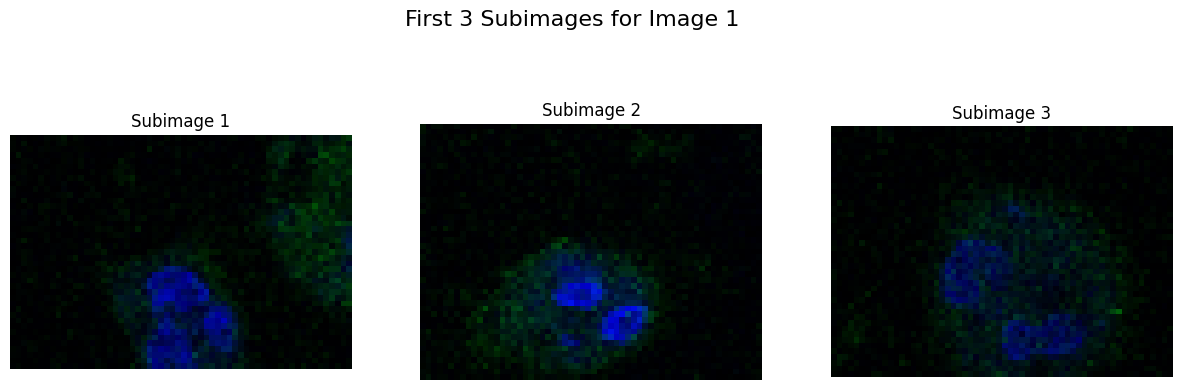

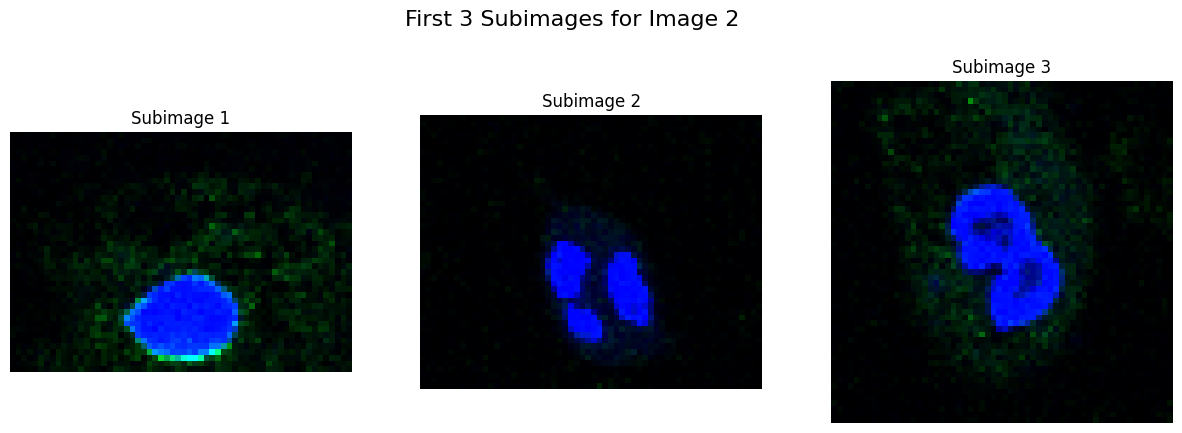

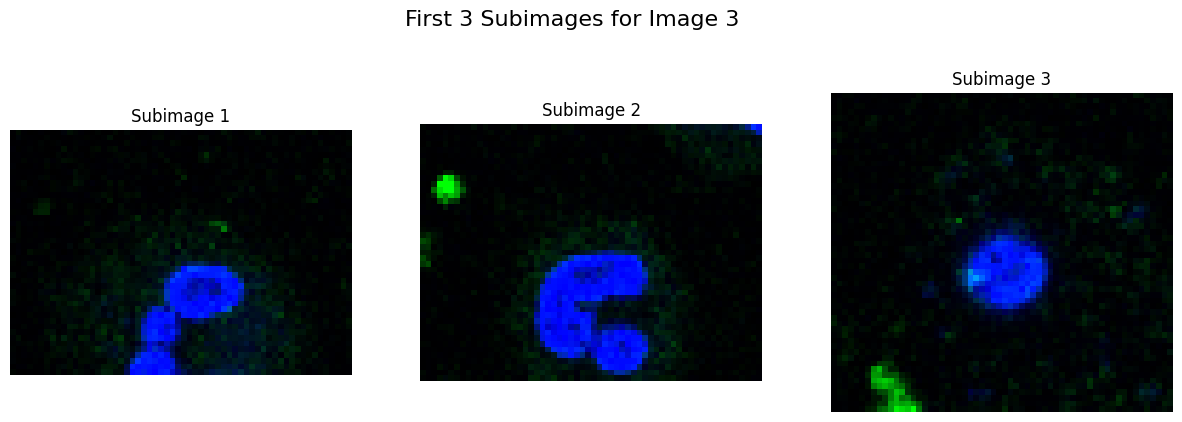

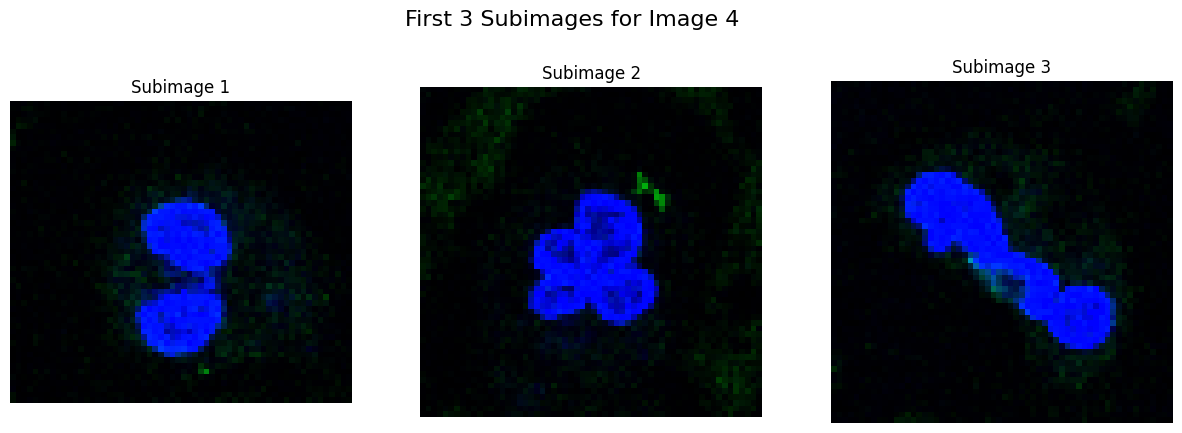

In [9]:
display_first_three_subimages(subimages)

Prediction probabilities: [[9.99875841e-01 1.24158876e-04]]


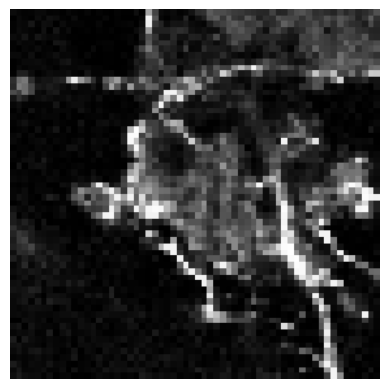

(0, array([[9.99875841e-01, 1.24158876e-04]]))

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import joblib
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime

# Load the trained logistic regression model, StandardScaler, and PCA
MODEL_SAVE_PATH = '../models/logistic_regression_model_DOP_v2.pkl'
SCALER_SAVE_PATH = '../models/scaler_v2.pkl'
PCA_SAVE_PATH = '../models/pca_v2.pkl'

model = joblib.load(MODEL_SAVE_PATH)
scaler = joblib.load(SCALER_SAVE_PATH)
pca = joblib.load(PCA_SAVE_PATH)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def predict_and_display_image(image_path, model, scaler, pca, img_size=IMG_SIZE):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, -1))  # Flatten the image
    img_array = img_array / 255.0  # Rescale the image

    # Apply StandardScaler and PCA
    img_array_scaled = scaler.transform(img_array)
    img_array_pca = pca.transform(img_array_scaled)

    # Make a prediction
    prediction_prob = model.predict_proba(img_array_pca)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]

    print(f"Prediction probabilities: {prediction_prob}")

    # Display the image
    plt.imshow(img_array.reshape(img_size), cmap='gray')
    plt.axis('off')
    plt.show()

    return predicted_class, prediction_prob

# Predict the class of a specific image from the test set
# Change: Dynamically generate the subimage path
subimage_path = os.path.join(subimages_output_folder, f"output_{timestamp}", 'subimages', '20211111.lif_ctr 3.11.21NET488_MPO633_011_sub_image_48.png')
predict_and_display_image(subimage_path, model, scaler, pca)

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import joblib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from datetime import datetime

# Load the trained logistic regression model, StandardScaler, and PCA
MODEL_SAVE_PATH = '../models/logistic_regression_model_DOP_v2.pkl'
SCALER_SAVE_PATH = '../models/scaler_v2.pkl'
PCA_SAVE_PATH = '../models/pca_v2.pkl'

model = joblib.load(MODEL_SAVE_PATH)
scaler = joblib.load(SCALER_SAVE_PATH)
pca = joblib.load(PCA_SAVE_PATH)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def predict_image(image_path, model, scaler, pca, img_size=IMG_SIZE):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, -1))  # Flatten the image
    img_array = img_array / 255.0  # Rescale the image

    # Apply StandardScaler and PCA
    img_array_scaled = scaler.transform(img_array)
    img_array_pca = pca.transform(img_array_scaled)

    # Make a prediction
    prediction_prob = model.predict_proba(img_array_pca)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]

    return predicted_class, prediction_prob

def predict_and_save_results(subimages_folder, model, scaler, pca, output_csv_path):
    results = []

    for root, dirs, files in os.walk(subimages_folder):
        for file in files:
            if file.endswith('.png'):
                print(file)
                image_path = os.path.join(root, file)
                predicted_class, prediction_prob = predict_image(image_path, model, scaler, pca)

                # Extract original image name and subimage number from file path
                original_image_name = os.path.basename(file)
                index = original_image_name.find('_sub_image')
                original_image_name = original_image_name[:index]
                subimage_number = file.split('_')[-1].split('.')[0]

                # Append result to the list
                results.append({
                    'Original Image': original_image_name,
                    'Subimage Number': subimage_number,
                    'Predicted Category': predicted_class,
                    'Probabilities': prediction_prob.tolist()  # Convert array to list for CSV
                })

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

    return results_df

# Predict and save results for all subimages
subimages_folder = os.path.join(subimages_output_folder, f"output_{timestamp}", 'subimages')  # Adjust the path to your subimages folder
output_csv_path = f'results/{timestamp}_predictions_subimages.csv'
results_df = predict_and_save_results(subimages_folder, model, scaler, pca, output_csv_path)


20211111.lif_ctr 3.11.21NET488_MPO633_017_sub_image_72.png
20211111.lif_ctr 3.11.21NET488_MPO633_017_sub_image_66.png
20211111.lif_ctr 3.11.21NET488_MPO633_011_sub_image_107.png
20211111.lif_ctr 3.11.21NET488_MPO633_011_sub_image_113.png
20211111.lif_ctr 3.11.21NET488_MPO633_017_sub_image_99.png
20211111.lif_ctr 3.11.21NET488_MPO633_014_sub_image_93.png
20211111.lif_ctr 3.11.21NET488_MPO633_014_sub_image_87.png
20211111.lif_ctr 3.11.21NET488_MPO633_017_sub_image_6.png
20211111.lif_ctr 3.11.21NET488_MPO633_014_sub_image_50.png
20211111.lif_ctr 3.11.21NET488_MPO633_014_sub_image_44.png
20211111.lif_ctr 3.11.21NET488_MPO633_014_sub_image_104.png
20211111.lif_ctr 3.11.21NET488_MPO633_014_sub_image_110.png
20211111.lif_ctr 3.11.21NET488_MPO633_014_sub_image_78.png
20211111.lif_ctr 3.11.21NET488_MPO633_011_sub_image_22.png
20211111.lif_ctr 3.11.21NET488_MPO633_011_sub_image_36.png
20211111.lif_ctr 3.11.21NET488_MPO633_021_sub_image_90.png
20211111.lif_ctr 3.11.21NET488_MPO633_021_sub_image_8

In [12]:
results_df

,Original Image,Subimage Number,Predicted Category,Probabilities
0,20211111.lif_ctr 3.11.21NET488_MPO633_017,72,0,"[[0.9503688189494216, 0.049631181050578364]]"
1,20211111.lif_ctr 3.11.21NET488_MPO633_017,66,0,"[[0.9945704898536456, 0.005429510146354346]]"
2,20211111.lif_ctr 3.11.21NET488_MPO633_011,107,0,"[[0.9682172039028599, 0.031782796097140055]]"
3,20211111.lif_ctr 3.11.21NET488_MPO633_011,113,0,"[[0.989270334489905, 0.010729665510095071]]"
4,20211111.lif_ctr 3.11.21NET488_MPO633_017,99,0,"[[0.9918013851654828, 0.008198614834517243]]"
...,...,...,...,...
475,20211111.lif_ctr 3.11.21NET488_MPO633_017,80,0,"[[0.99493501304032, 0.005064986959680057]]"
476,20211111.lif_ctr 3.11.21NET488_MPO633_017,94,0,"[[0.9296192602117299, 0.07038073978827013]]"
477,20211111.lif_ctr 3.11.21NET488_MPO633_011,122,0,"[[0.922265128962841, 0.07773487103715902]]"
478,20211111.lif_ctr 3.11.21NET488_MPO633_017,43,1,"[[1.925262971491648e-06, 0.9999980747370285]]"


In [13]:
image_summary = results_df[['Original Image', 'Predicted Category', 'Subimage Number']].groupby(['Original Image','Predicted Category']).count().reset_index()

In [14]:
image_summary['Predicted Category'] = image_summary['Predicted Category'].replace({0: 'NET negative', 1: 'NET positive'})

In [15]:
image_summary

,Original Image,Predicted Category,Subimage Number
0,20211111.lif_ctr 3.11.21NET488_MPO633_011,NET negative,129
1,20211111.lif_ctr 3.11.21NET488_MPO633_011,NET positive,12
2,20211111.lif_ctr 3.11.21NET488_MPO633_014,NET negative,110
3,20211111.lif_ctr 3.11.21NET488_MPO633_014,NET positive,10
4,20211111.lif_ctr 3.11.21NET488_MPO633_017,NET negative,118
5,20211111.lif_ctr 3.11.21NET488_MPO633_017,NET positive,8
6,20211111.lif_ctr 3.11.21NET488_MPO633_021,NET negative,84
7,20211111.lif_ctr 3.11.21NET488_MPO633_021,NET positive,9


In [16]:
percents = []
for i, h in image_summary.iterrows():
    if i < 7 and i % 2 == 0:
        ratio = image_summary['Subimage Number'][i+1] / (image_summary['Subimage Number'][i] + image_summary['Subimage Number'][i+1]) * 100
        percents.append(ratio)
        percents.append(ratio)

In [18]:
image_summary['NET Positive Ratio'] = percents

In [19]:
image_summary

,Original Image,Predicted Category,Subimage Number,NET Positive Ratio
0,20211111.lif_ctr 3.11.21NET488_MPO633_011,NET negative,129,8.510638
1,20211111.lif_ctr 3.11.21NET488_MPO633_011,NET positive,12,8.510638
2,20211111.lif_ctr 3.11.21NET488_MPO633_014,NET negative,110,8.333333
3,20211111.lif_ctr 3.11.21NET488_MPO633_014,NET positive,10,8.333333
4,20211111.lif_ctr 3.11.21NET488_MPO633_017,NET negative,118,6.349206
5,20211111.lif_ctr 3.11.21NET488_MPO633_017,NET positive,8,6.349206
6,20211111.lif_ctr 3.11.21NET488_MPO633_021,NET negative,84,9.677419
7,20211111.lif_ctr 3.11.21NET488_MPO633_021,NET positive,9,9.677419


In [20]:
output_csv_path2 = f'results/{timestamp}_predictions_whole_image.csv'
# Convert results to DataFrame and save to CSV
image_summary.to_csv(output_csv_path2, index=False)
print(f"Whole image results saved to {output_csv_path2}")

Whole image results saved to results/2024-06-17_22-36_predictions_whole_image.csv


In [21]:
image_summary['Original Image']

0    20211111.lif_ctr 3.11.21NET488_MPO633_011
1    20211111.lif_ctr 3.11.21NET488_MPO633_011
2    20211111.lif_ctr 3.11.21NET488_MPO633_014
3    20211111.lif_ctr 3.11.21NET488_MPO633_014
4    20211111.lif_ctr 3.11.21NET488_MPO633_017
5    20211111.lif_ctr 3.11.21NET488_MPO633_017
6    20211111.lif_ctr 3.11.21NET488_MPO633_021
7    20211111.lif_ctr 3.11.21NET488_MPO633_021
Name: Original Image, dtype: object

In [22]:
df_mean_percent = image_summary[['NET Positive Ratio', 'Original Image']].groupby('Original Image').mean().reset_index()
df_mean_percent

,Original Image,NET Positive Ratio
0,20211111.lif_ctr 3.11.21NET488_MPO633_011,8.510638
1,20211111.lif_ctr 3.11.21NET488_MPO633_014,8.333333
2,20211111.lif_ctr 3.11.21NET488_MPO633_017,6.349206
3,20211111.lif_ctr 3.11.21NET488_MPO633_021,9.677419


In [23]:
mean_percent = df_mean_percent['NET Positive Ratio'].mean()
mean_percent

8.217649333812682

In [24]:
df_total_sum = image_summary[['Predicted Category', 'Subimage Number']].groupby('Predicted Category').sum().reset_index()
df_total_sum

,Predicted Category,Subimage Number
0,NET negative,441
1,NET positive,39


Text(0.5, 1.0, 'Total counted cells of all images\nmean NET positive ratio: 8.22')

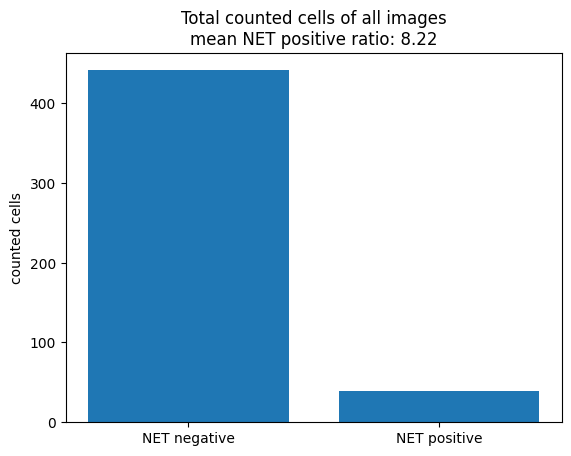

In [25]:
plt.bar(df_total_sum['Predicted Category'], df_total_sum['Subimage Number'], width=0.8, align='center', color=None, label=None)
plt.ylabel('counted cells')
plt.title(f'''Total counted cells of all images
mean NET positive ratio: {round(mean_percent,2)}''')